In [1]:
%matplotlib notebook
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import seaborn as sns

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(x, 0)

def linear(x):
    return x

In [3]:
# Make data.
w1 = np.arange(-5, 5, 0.25)
w2 = np.arange(-5, 5, 0.25)
w1, w2 = np.meshgrid(w1, w2)

x1 = 1.
y1 = 0
x2 = -1
y2 = 1
f = (sigmoid(sigmoid(x1*w1)*w2) - y1) ** 2 \
+ (sigmoid(sigmoid(x2*w1)*w2) - y2) ** 2 \
+ (sigmoid(sigmoid(0.4*w1)*w2) - 1) ** 2 \
+ (sigmoid(sigmoid(-0.4*w1)*w2) - 0) ** 2
# f = (sigmoid(relu(x*w1)*w2) - y) ** 2
# f = (sigmoid(linear(x*w1)*w2) - y) ** 2

<IPython.core.display.Javascript object>


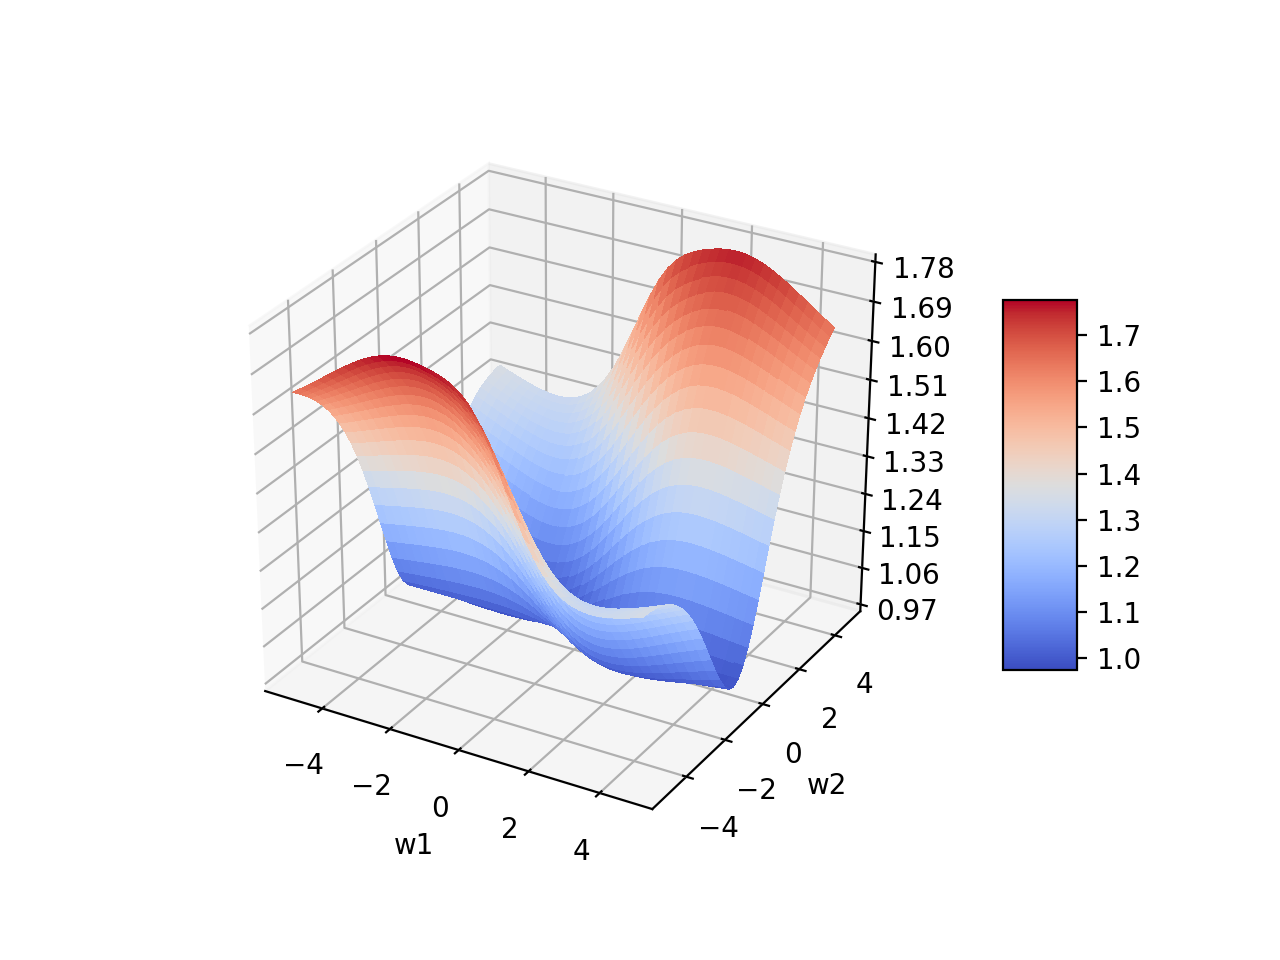

In [4]:
fig = plt.figure()
ax = fig.gca(projection='3d')


# Plot the surface.
surf = ax.plot_surface(w1, w2, f, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('w1')
ax.set_ylabel('w2')
plt.show()


In [69]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, 1])
y_ = tf.placeholder(tf.float32, [None, 1])


n_input = 1
n_hidden = 1
n_output = 1
lmd = 0


rang = 5.
parameters = tf.Variable(tf.concat([
                                    tf.random_uniform([1], minval= -5, maxval= 5, seed=1),
                                    tf.random_uniform([1], minval= -8, maxval= 2, seed=2),
                                   ], 0))

weights1 = tf.reshape(tf.slice(parameters, begin=[0], size=[1]), [1, 1])
hidden = tf.nn.sigmoid(tf.matmul(x, weights1) + 1)

weights2 = tf.reshape(tf.slice(parameters, begin=[1], size=[1]), [1, 1])
y = tf.nn.sigmoid(tf.matmul(hidden, weights2)-0.2)

loss = tf.reduce_mean(tf.reduce_sum(tf.pow(y_ - y, 2), reduction_indices=[1])) #I also tried simply tf.nn.l2_loss(y_ - y)

lr = tf.placeholder(tf.float32, shape=[])
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
grads_and_vars = optimizer.compute_gradients(loss)
grad = tf.gradients(loss, parameters)
hess = tf.hessians(loss, parameters)
train_step = optimizer.apply_gradients(grads_and_vars)

In [13]:
def cg(A, b, it, x=None):
#     A: 2d numpy.array of positive semi-definite (symmetric) matrix
#     b: 1d numpy.array
#     x: 1d numpy.array of initial point

    A = np.array(A)
    b = np.array(b)
#     print (A, b)
    n = len(b)
    if not x:
        x = np.ones(n)
    r = np.dot(A, x) - b
    p = - r
    r_k_norm = np.dot(r, r)
    for i in range(it):
        Ap = np.dot(A, p)
        alpha = r_k_norm / np.dot(p, Ap)
        if alpha < 0:
#             print ('Neg Itr:', i)
            return p, i+1
        x += alpha * p
        r += alpha * Ap
        r_kplus1_norm = np.dot(r, r)
        beta = r_kplus1_norm / r_k_norm
        r_k_norm = r_kplus1_norm
        if r_kplus1_norm < 1e-5:
#             print ('Itr:', i)
            break
        p = beta * p - r
    return x, -1

In [79]:
def get_accuracy(predy):
    match = [(predy[i] - 0.5) * (label[i] - 0.5) > 0  for i in range(n*2)]
    acc = sum(match)*1./2/n
    return acc[0]

def get_norm_grad(grad):
    nng = 0.
    for g in grad:
        nng += np.linalg.norm(g) ** 2
    return np.sqrt(nng)
    
     
def displayH(a):
    a = np.array(a[0])
#     print ("Matrix["+("%d" %a.shape[0])+"]["+("%d" %a.shape[1])+"]")
    rows = a.shape[0]
    cols = a.shape[1]
    for i in range(0, rows):
        for j in range(0, cols):
            print("%0.2g " %a[i,j], end="")
        print ()
    print ()

<IPython.core.display.Javascript object>


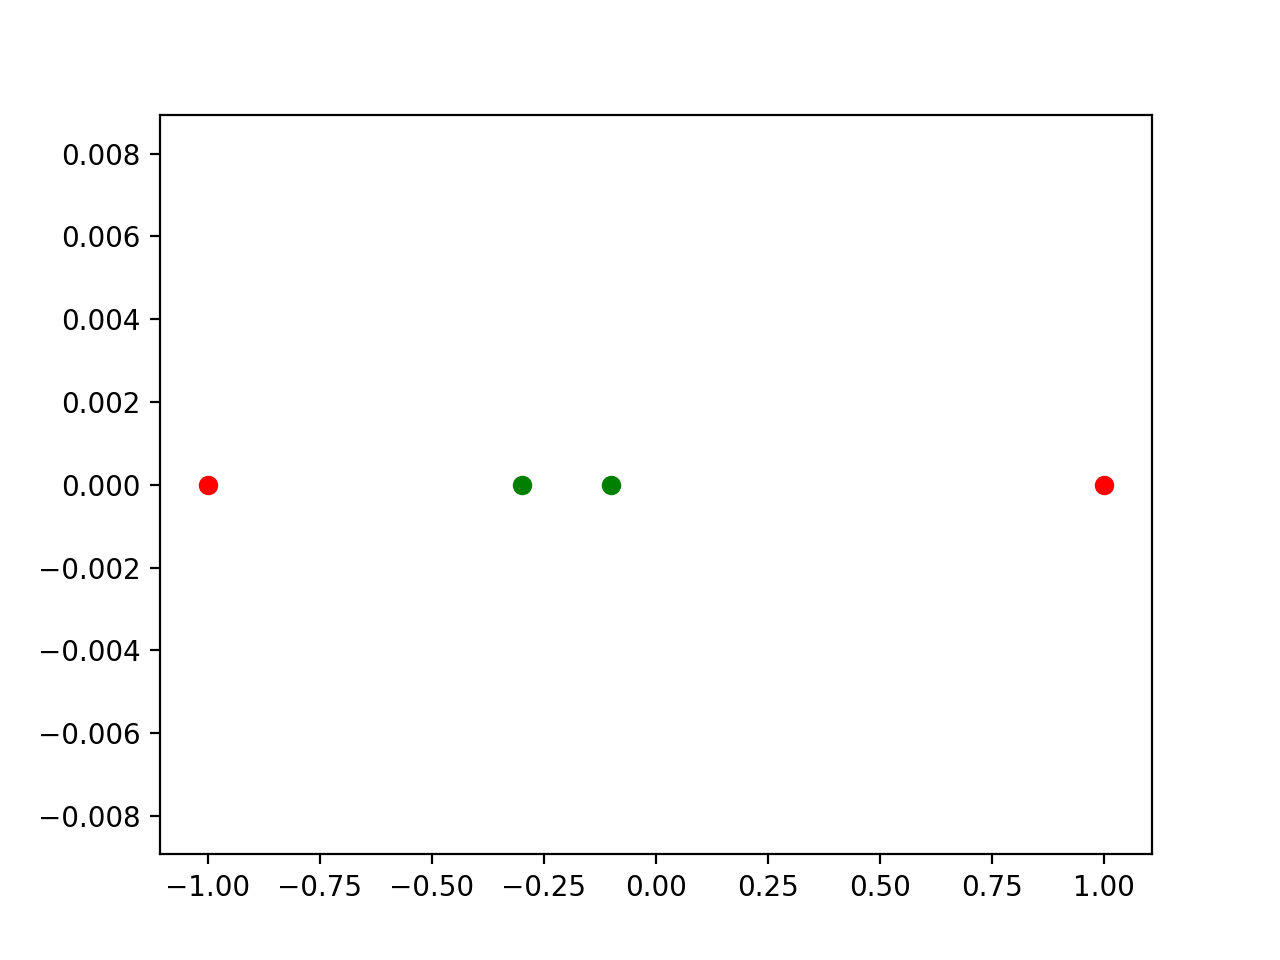

In [80]:
# n = 6
# data = [[-1], [-0.6], [-0.2], [0.2], [0.6], [1]] \
#     + [[-0.8], [-0.4], [0], [0.4], [0.8], [0.9]]
n = 2
data = [[-1], [1]] \
    + [[-0.1], [-0.3]]
# n = 10
# data = [[-1], [-0.8], [-0.6], [-0.4], [-0.2], [0.2], [0.4], [0.6], [0.8], [1]] \
#     + [[-0.9], [-0.7], [-0.5], [-0.3], [-0.1], [0.1], [0.3], [0.5], [0.7], [0.9]]
label = [[1]] * n + [[0]] * n
data = np.array(data)
label = np.array(label)
# print (data, label)

fig = plt.figure()
plt.scatter(data[:n], [0]*n, color=['red'])
plt.scatter(data[n:], [0]*n, color=['green'])
plt.show()

In [58]:
sess = tf.InteractiveSession()
w1 = np.arange(-5, 5, 0.25)
w2 = np.arange(-8, 2, 0.25)
f = np.zeros((len(w1), len(w2)))
for i in range(len(w1)):
    for j in range(len(w2)):
        v = sess.run(loss, feed_dict={x: data, y_: label, parameters: [w1[i], w2[j]]})    
        f[j][i] = v
w1, w2 = np.meshgrid(w1, w2)
# v = sess.run(loss, feed_dict={x: data, y_: label, parameters: [0,-5]})    
# print (v)
sess.close() 

<IPython.core.display.Javascript object>


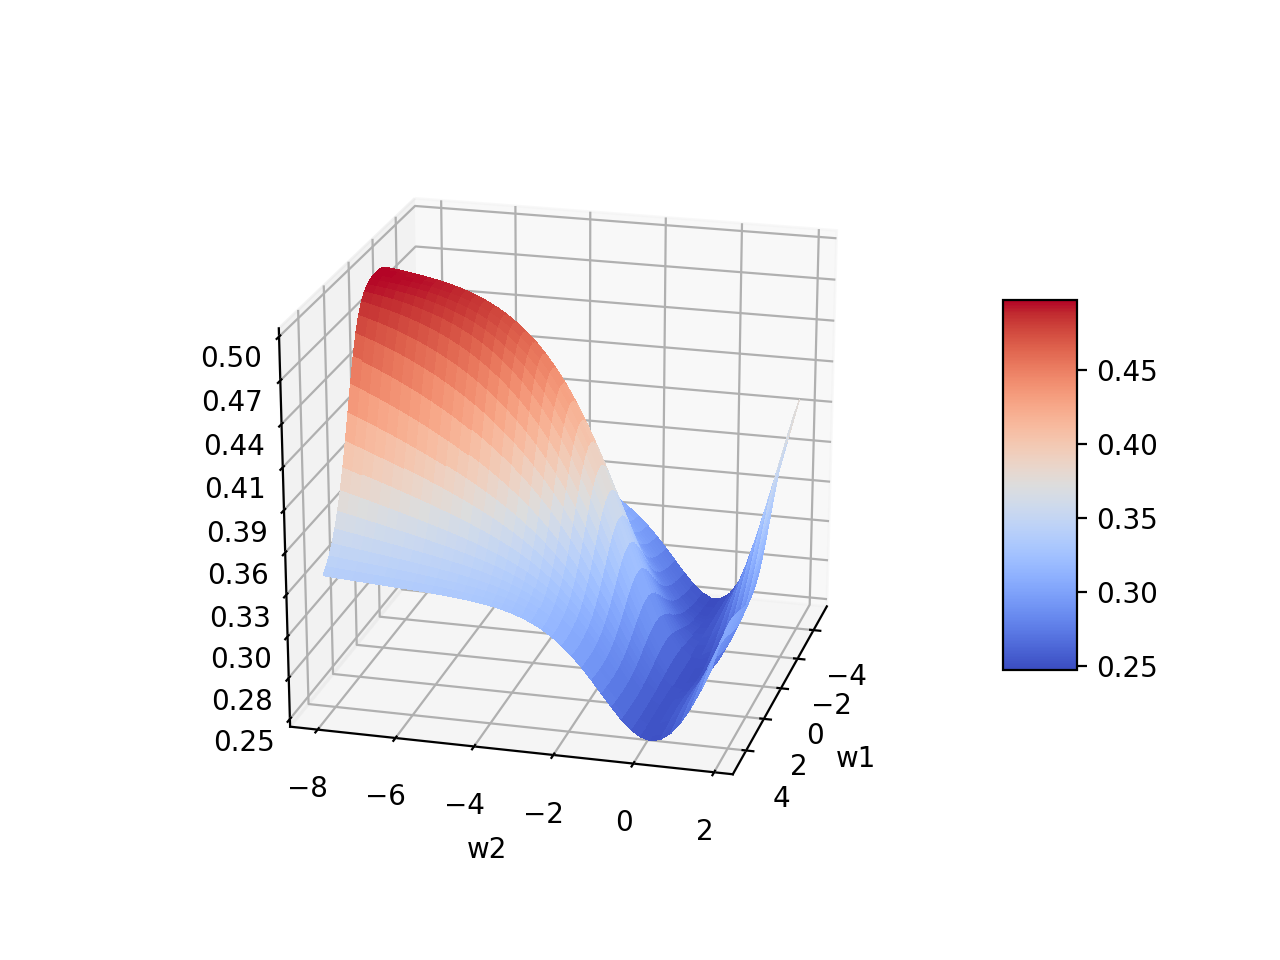

In [59]:
fig = plt.figure()
ax = fig.gca(projection='3d')


# Plot the surface.
surf = ax.plot_surface(w1, w2, f, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('w1')
ax.set_ylabel('w2')
plt.show()

In [36]:
sess = tf.InteractiveSession()
dic = {}
nr = 100
cgIt = 2
stepsize = [1e1, 1e-0, 1e-1, 1e-2]

rts = []
for r in range(nr):
    
    tf.global_variables_initializer().run()
    v0, g, H, w = sess.run([loss, grad, hess, parameters], feed_dict={x: data, y_: label})    
    w0 = w
#     displayH(H)
    d, status = cg(H[0], g[0], cgIt)
    
    eig,eigvec = np.linalg.eig(H[0])
    leftmost = eigvec[np.argmin(eig)]
    ss = 1.
    while True:
        w_cg = w0 - ss * leftmost
        v_cg = sess.run(loss, feed_dict={x: data, y_: label, parameters: w_cg})    
        if v_cg >= v0:
            ss = -ss * 0.5
        else:
            break

    ss = 1.
    if status > 0:
        while True:
            w_cg = w0 - ss * d
            v_cg = sess.run(loss, feed_dict={x: data, y_: label, parameters: w_cg})    
            if v_cg >= v0:
                ss = -ss * 0.5
            else:
                break
    else:
        while True:
            w_cg = w0 - ss * d
            v_cg = sess.run(loss, feed_dict={x: data, y_: label, parameters: w_cg})    
            if v_cg >= v0:
                ss = -ss * 0.5
            else:
                break
  
    ss = 1.
    while True:
        w_gd = w0 - ss * g[0]
        v_gd = sess.run(loss, feed_dict={x: data, y_: label, parameters: w_gd})    
        if v_gd >= v0:
            ss = ss * 0.5
        else:
            break

    rt = (v_gd-v0) / (v_cg-v0)
    rts.append(rt)
    Hg = np.dot(H[0], g[0])
    gHg = np.dot(g[0], Hg)
    Hd = np.dot(H[0], d)
    dHd = np.dot(d, Hg)
#     print (gHg, dHd, rt)
    

sess.close() 

Two cases:

    status<0, CG is better than GD
    
    status>0 and find a neg curvature, CG is worse than GD due to dHd is close to 0

<IPython.core.display.Javascript object>


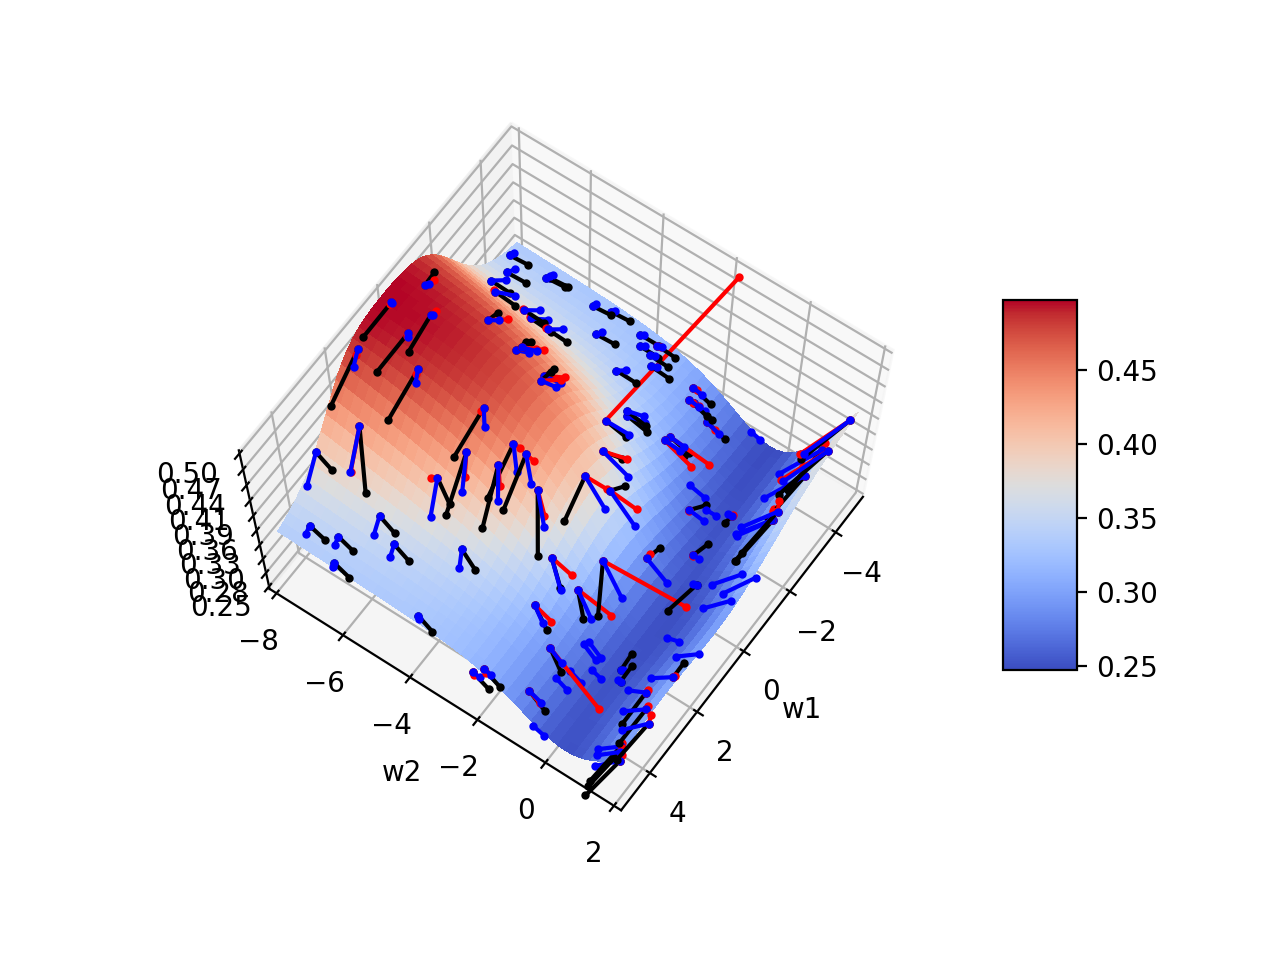

In [82]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(w1, w2, f, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


sess = tf.InteractiveSession()
cgIt = 5

nr = 100
for r in range(nr):

    tf.global_variables_initializer().run()
    v0, g, H, w = sess.run([loss, grad, hess, parameters], feed_dict={x: data, y_: label})    
    w0 = w
 
    eig,eigvec = np.linalg.eig(H[0])
    leftmost = eigvec[np.argmin(eig)]
    ss = 1.
    if min(eig) < 0:
        while True:
            w_nc = w0 - ss * leftmost
            v_nc = sess.run(loss, feed_dict={x: data, y_: label, parameters: w_nc})    
            if v_nc >= v0:
                ss = -ss * 0.5
            else:
                break
        ax.plot([w[0], w_nc[0]], [w[1], w_nc[1]], [v0, v_nc], '-ko', markersize=2)

#     displayH(H)
    d, status = cg(H[0], g[0], cgIt)

    ss = 10.
    if status > 0:
        while True:
            w_cg = w0 - ss * d
            v_cg = sess.run(loss, feed_dict={x: data, y_: label, parameters: w_cg})    
            if v_cg >= v0:
                ss = -ss * 0.5
            else:
                break
        ax.plot([w[0], w_cg[0]], [w[1], w_cg[1]], [v0, v_cg], '-ro', markersize=2)

    else:
        while True:
            w_cg = w0 - ss * d
            v_cg = sess.run(loss, feed_dict={x: data, y_: label, parameters: w_cg})    
            if v_cg >= v0:
                ss = -ss * 0.5
            else:
                break
#         ax.plot([w[0], w_cg[0]], [w[1], w_cg[1]], [v0, v_cg], '-ro', markersize=2)

    
    ss = 10.
    while True:
        w_gd = w0 - ss * g[0]
        v_gd = sess.run(loss, feed_dict={x: data, y_: label, parameters: w_gd})    
        if v_gd >= v0:
            ss = ss * 0.5
        else:
            break
#     print (w, w_gd)
    ax.plot([w[0], w_gd[0]], [w[1], w_gd[1]], [v0, v_gd], '-bo', markersize=2)
        
    rt = (v_gd-v0) / (v_cg-v0)
#     print (rt)
    
    
ax.set_xlim(-5, 5)
ax.set_ylim(-8, 2)    
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.view_init(70, 35)
plt.show()

plt.savefig('report1/2w.eps', format='eps')
sess.close() 


In [106]:
sess = tf.InteractiveSession()
dic = {}
nr = 10
ni = 100
cgIt = 5
stepsize = [1e1, 1e-0, 1e-1, 1e-2]

rts = []
for r in range(nr):
    
    print (r)

    tf.global_variables_initializer().run()
    v0, g, H, pd, w0 = sess.run([loss, grad, hess, y, parameters], feed_dict={x: data, y_: label})    
    dic[r] = {'w0': w0}    
    nng = get_norm_grad(g)
    acc = get_accuracy(pd)*100
    eig = sorted(np.linalg.eigvals(H)[0])
    print("Init: Iter {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g},nnw {:.4g}, low_eig {:.4g}."\
            .format(0, acc, v0, nng, np.linalg.norm(w0[:]), min(eig) ))
    
    w_cg = w0
    dic[r]['cg'] = {'v':[], 'nng':[], 'acc':[], 'emin':[], 'w':[]}
    for i in range(ni):
        vOld, g, H, pd, wOld= sess.run([loss, grad, hess, y, parameters], feed_dict={x: data, y_: label, parameters: w_cg})    
        d, status = cg(H[0], g[0], cgIt)
        ss = 5.
        while True:
            w_cg = wOld - ss * d
            v_cg = sess.run(loss, feed_dict={x: data, y_: label, parameters: w_cg})    
            if v_cg >= vOld and np.abs(ss)>1e-5:
                ss = -ss * 0.5
            else:
                break
        vOld, g, H, pd, wOld= sess.run([loss, grad, hess, y, parameters], feed_dict={x: data, y_: label, parameters: w_cg})    
        nng = get_norm_grad(g)
        acc = get_accuracy(pd)*100
#         eig,eigvec = np.linalg.eig(H[0])
        dic[r]['cg']['v'].append(vOld) 
        dic[r]['cg']['nng'].append(nng)
        dic[r]['cg']['acc'].append(acc)
        dic[r]['cg']['emin'].append(min(eig))
        dic[r]['cg']['w'].append(w_cg)
    print("CG: Iter {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g},nnw {:.4g}, low_eig {:.4g}."\
            .format(i+1, acc, vOld, nng, np.linalg.norm(wOld[:]), min(eig) ))

    
    
    w_nc = w0
    dic[r]['nc'] = {'v':[], 'nng':[], 'acc':[], 'emin':[], 'w':[]}
    for i in range(ni):
        vOld, g, H, pd, wOld= sess.run([loss, grad, hess, y, parameters], feed_dict={x: data, y_: label, parameters: w_nc})    
        eig,eigvec = np.linalg.eig(H[0])
        leftmost = eigvec[np.argmin(eig)]
        ss = 1.
        while True:
            w_nc = wOld - ss * leftmost
            v_nc = sess.run(loss, feed_dict={x: data, y_: label, parameters: w_nc})    
            if v_nc >= vOld and np.abs(ss)>1e-4:
                ss = -ss * 0.5
            else:
                break
        vOld, g, H, pd, wOld = sess.run([loss, grad, hess, y, parameters], feed_dict={x: data, y_: label, parameters: w_nc})    
        nng = get_norm_grad(g)
        acc = get_accuracy(pd)*100
        eig,eigvec = np.linalg.eig(H[0])
        dic[r]['nc']['v'].append(vOld) 
        dic[r]['nc']['nng'].append(nng)
        dic[r]['nc']['acc'].append(acc)
        dic[r]['nc']['emin'].append(min(eig))
        dic[r]['nc']['w'].append(w_nc)
    print("NC: Iter {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g},nnw {:.4g}, low_eig {:.4g}."\
        .format(i+1, acc, vOld, nng, np.linalg.norm(wOld[:]), min(eig) ))

    w_gd = w0
    dic[r]['gd'] = {'v':[], 'nng':[], 'acc':[], 'emin':[], 'w':[]}
    for i in range(ni):
        vOld, g, wOld= sess.run([loss, grad, parameters], feed_dict={x: data, y_: label, parameters: w_gd})    
        ss = 5.
        while True:
            w_gd = wOld - ss * g[0]
            v_gd = sess.run(loss, feed_dict={x: data, y_: label, parameters: w_gd})    
#                 print (v_nc)
            if v_gd >= vOld and np.abs(ss)>1e-4:
                ss = -ss * 0.5
            else:
                break
        vOld, g, H, pd, wOld= sess.run([loss, grad, hess, y, parameters], feed_dict={x: data, y_: label, parameters: w_gd})    
        nng = get_norm_grad(g)
        acc = get_accuracy(pd)*100
        eig,eigvec = np.linalg.eig(H[0])
        dic[r]['gd']['v'].append(vOld) 
        dic[r]['gd']['nng'].append(nng)
        dic[r]['gd']['acc'].append(acc)
        dic[r]['gd']['emin'].append(min(eig))
        dic[r]['gd']['w'].append(w_gd)
    print("GD: Iter {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g},nnw {:.4g}, low_eig {:.4g}."\
        .format(i+1, acc, vOld, nng, np.linalg.norm(wOld[:]), min(eig) ))

sess.close() 

0
Init: Iter 0, accuracy 50.00%, loss 0.276594, nng 0.04204,nnw 2.878, low_eig 3.969e-05.


/Users/Schemmy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


CG: Iter 100, accuracy 0.00%, loss nan, nng nan,nnw nan, low_eig 3.969e-05.
NC: Iter 100, accuracy 50.00%, loss 0.242414, nng 0.004347,nnw 52.49, low_eig 3.704e-07.
GD: Iter 100, accuracy 50.00%, loss 0.248936, nng 0.00169,nnw 3.763, low_eig 0.0006514.
1
Init: Iter 0, accuracy 50.00%, loss 0.387373, nng 0.05368,nnw 6.598, low_eig -0.003037.
CG: Iter 100, accuracy 50.00%, loss 0.325579, nng 4.536e-10,nnw 31.54, low_eig -0.003037.
NC: Iter 100, accuracy 50.00%, loss 0.248450, nng 0.02495,nnw 48.93, low_eig 5.754e-07.
GD: Iter 100, accuracy 50.00%, loss 0.317988, nng 0.008976,nnw 7.209, low_eig -0.007449.
2
Init: Iter 0, accuracy 50.00%, loss 0.383064, nng 0.05842,nnw 3.399, low_eig -0.02056.
CG: Iter 100, accuracy 75.00%, loss 0.176904, nng 1.601e-09,nnw 244.8, low_eig -0.02056.
NC: Iter 100, accuracy 50.00%, loss 0.242368, nng 0.003343,nnw 50.38, low_eig 4.517e-07.
GD: Iter 100, accuracy 50.00%, loss 0.248889, nng 0.001672,nnw 3.791, low_eig 0.0006531.
3
Init: Iter 0, accuracy 50.00%, l

<IPython.core.display.Javascript object>


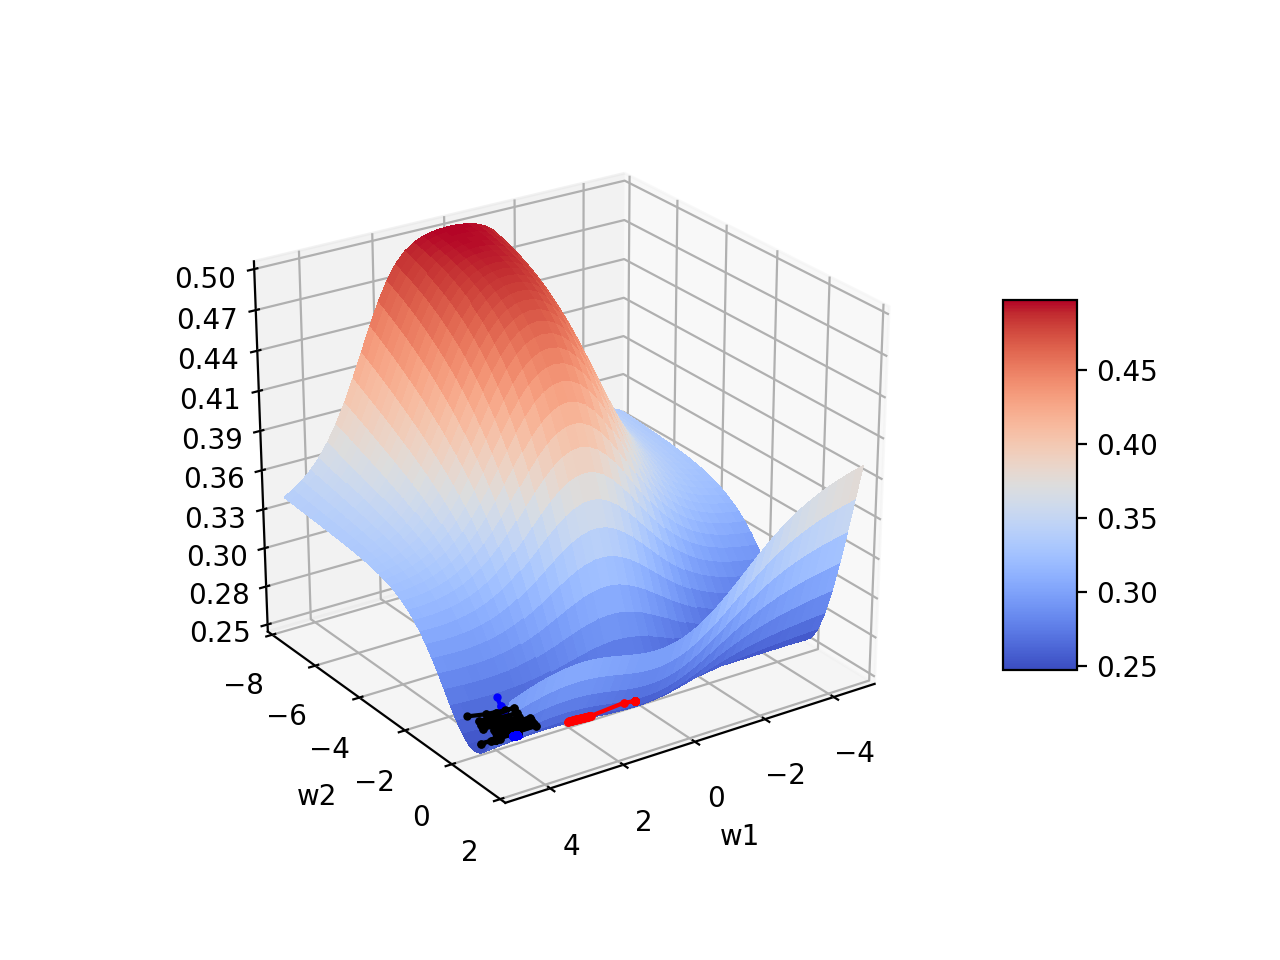

In [108]:
r = 3
fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(w1, w2, f, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# ax.plot([dic[r]['w0'][0], dic[r]['cg']['w'][0][0]], 
#         [dic[r]['w0'][1], dic[r]['cg']['w'][0][1]]
#         , [v0, v_nc], '-ko', markersize=2)

for i in range(ni-1):
    ax.plot([dic[r]['cg']['w'][i][0], dic[r]['cg']['w'][i+1][0]],
            [dic[r]['cg']['w'][i][1], dic[r]['cg']['w'][i+1][1]],
            [dic[r]['cg']['v'][i], dic[r]['cg']['v'][i+1]],
            '-ro', markersize=2)
    ax.plot([dic[r]['nc']['w'][i][0], dic[r]['nc']['w'][i+1][0]],
            [dic[r]['nc']['w'][i][1], dic[r]['nc']['w'][i+1][1]],
            [dic[r]['nc']['v'][i], dic[r]['nc']['v'][i+1]],
            '-ko', markersize=2)
    ax.plot([dic[r]['gd']['w'][i][0], dic[r]['gd']['w'][i+1][0]],
            [dic[r]['gd']['w'][i][1], dic[r]['gd']['w'][i+1][1]],
            [dic[r]['gd']['v'][i], dic[r]['gd']['v'][i+1]],
            '-bo', markersize=2)
    
ax.set_xlim(-5, 5)
ax.set_ylim(-8, 2)    
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.view_init(70, 35)
plt.show()
